In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from data import create_data_gaussian, prepare_data_natural
from model import simple_model, get_train, get_val, prepare_data_reweighter, prepare_data_resampler, apply_reweighter, apply_resampler, resample
from plotting import plot_n, plot_n_ratio, plot_w, plot_w2

In [2]:
bins = np.arange(-3, 3, 0.1)

In [3]:
data = pos, neg, pos_weights, neg_weights = create_data_gaussian(4_000_000, neg_frac=0.15, neg_scale=0.2)

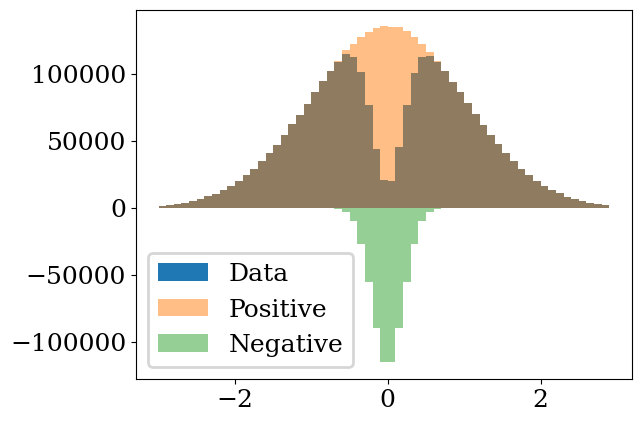

In [4]:
dat = x, _, w = prepare_data_natural(*data)
_, bins, __ = plt.hist(x, weights=w, bins=bins, label="Data")
pos, _, __ = plt.hist(pos, weights=pos_weights, bins=bins, alpha=0.5, label="Positive")
neg, _, __ = plt.hist(neg, weights=neg_weights, bins=bins, alpha=0.5, label="Negative")
plt.legend()

In [5]:
reweighter = simple_model()
reweighter.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])
x_train, y_train, w_train = get_train(*prepare_data_reweighter(*data))
reweighter.fit(x_train, y_train, sample_weight=w_train, epochs=1, validation_split=0.2, batch_size=256)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 837us/step - accuracy: 0.8503 - loss: 0.2883 - val_accuracy: 0.8501 - val_loss: 0.2798


In [6]:
resampler = simple_model()
resampler.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])
x_train, y_train, w_train, = get_train(*prepare_data_resampler(*data))
resampler.fit(x_train, y_train, sample_weight=w_train, epochs=1, validation_split=0.2, batch_size=256)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 12s 893us/step - accuracy: 0.4997 - loss: 0.5399 - val_accuracy: 0.5006 - val_loss: 0.5351


In [7]:
data_natural = get_val(*prepare_data_natural(*data))
data_reweighter = get_val(*apply_reweighter(*data, reweighter=reweighter))
data_resampler = get_val(*apply_resampler(*data, resampler=resampler))

400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


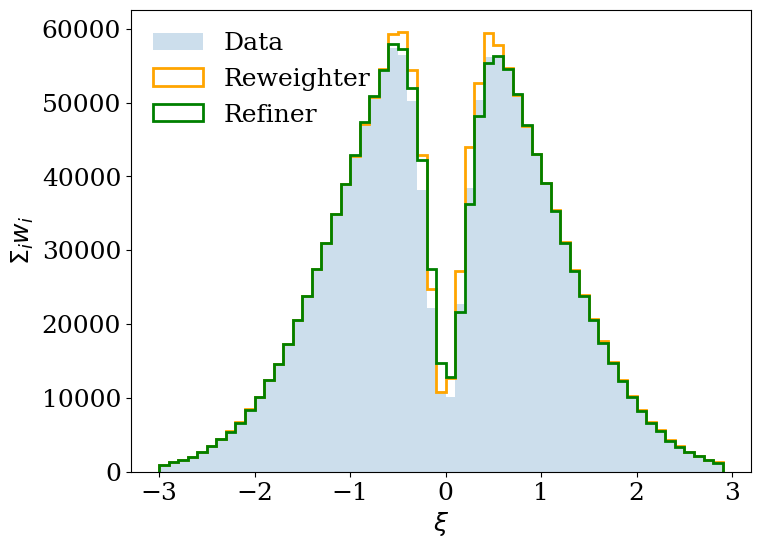

In [8]:
plot_n(data_natural, data_reweighter, data_resampler, bins=bins)

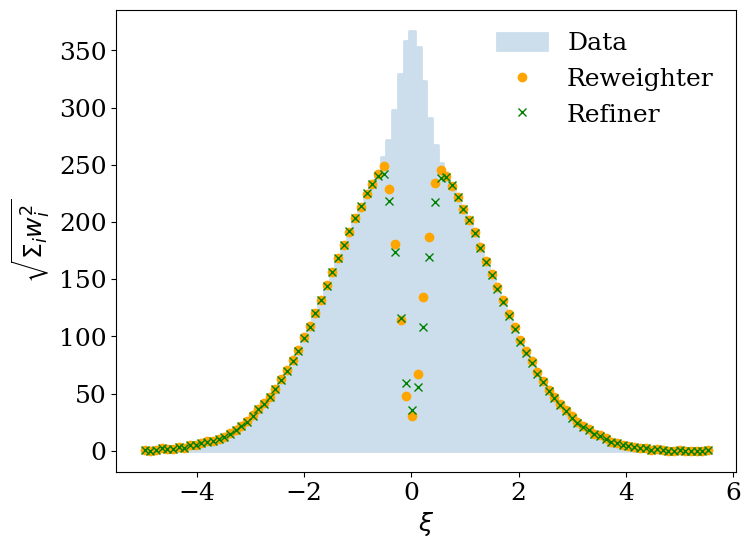

In [9]:
plot_w2(data_natural, data_reweighter, data_resampler)

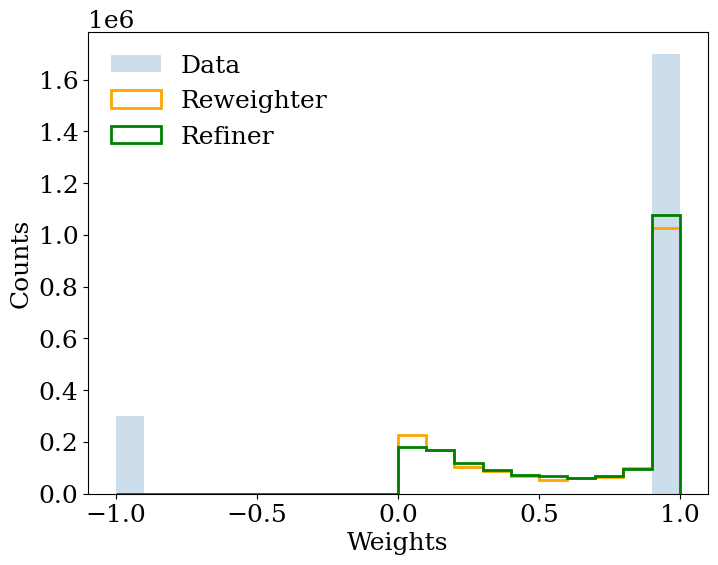

In [10]:
plot_w(data_natural, data_reweighter, data_resampler, bins=20)

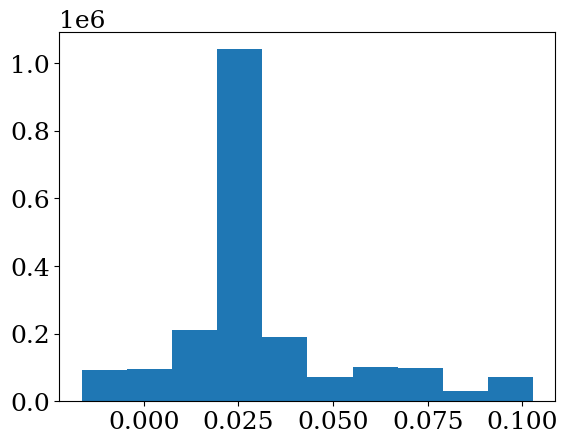

In [11]:
_, __, ___ = plt.hist(data_reweighter[-1] - data_resampler[-1])

In [12]:
# plt.plot(myhistory.history['val_loss'],label="val loss")
# plt.plot(myhistory.history['loss'],label="loss")
# plt.legend(frameon=False)

In [13]:
# plt.plot(myhistory.history['val_accuracy'],label="val accuracy")
# plt.plot(myhistory.history['accuracy'],label="accuracy")
# plt.legend(frameon=False)

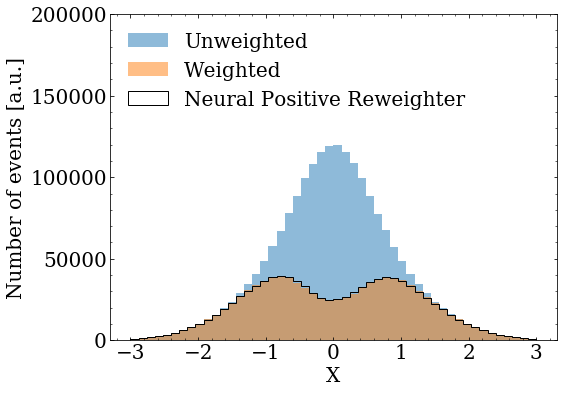

In [14]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position("both")
ax0.xaxis.set_ticks_position("both")
ax0.tick_params(direction="in", which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_, _, _ = plt.hist(
    X_val[Y_val == 0], bins=np.linspace(-3, 3, 51), alpha=0.5, label="Unweighted"
)
_, _, _ = plt.hist(
    X_val[Y_val == 1],
    weights=W_val[Y_val == 1],
    bins=np.linspace(-3, 3, 51),
    alpha=0.5,
    label="Weighted",
)
_, _, _ = plt.hist(
    X_val[Y_val == 0],
    weights=myw[Y_val == 0],
    bins=np.linspace(-3, 3, 51),
    label="Neural Positive Reweighter",
    histtype="step",
    color="black",
)
plt.legend(frameon=False, fontsize=20, loc="upper left")
plt.ylim([0, 200000])
plt.ylabel("Number of events [a.u.]", fontsize=20)
plt.xlabel("X", fontsize=20)
plt.locator_params(axis="y", nbins=6)
plt.savefig("gauss.pdf", bbox_inches="tight")

In [15]:
from scipy.stats import norm


def analytic_weight(x):
    gaus1 = norm.pdf(x) * 3
    gaus2 = norm.pdf(x, scale=0.5)
    return (gaus1 - gaus2) / (gaus1 + gaus2)

In [16]:
analytic_weights = analytic_weight(X_val)

## Now for reducing the stats.

In [17]:
keepprobs = myw[Y_val == 1] ** 2
for i in range(len(keepprobs)):
    if keepprobs[i] > 1.0:
        keepprobs[i] = 1.0
        pass
    pass
keep = np.random.binomial(1, keepprobs)
initweights = myw[Y_val == 1]
initxvals = X_val[Y_val == 1]
neweights = []
newxvals = []
for i in range(len(keep)):
    if keep[i] == 1:
        neweights += [1.0 / (0.00001 + initweights[i][0])]
        newxvals += [initxvals[i]]
    pass

In [13]:
data_reweighter_resampled = resample(*data_reweighter)
data_resampler_resampled = resample(*data_resampler)
len(data_reweighter_resampled[0]), len(data_resampler_resampled[0])

(1241088, 1156873)

In [11]:
plot_n_ratio(data_natural, data_reweighter_resampled, data_resampler_resampled, bins=bins)

NameError: name 'data_reweighter_resampled' is not defined

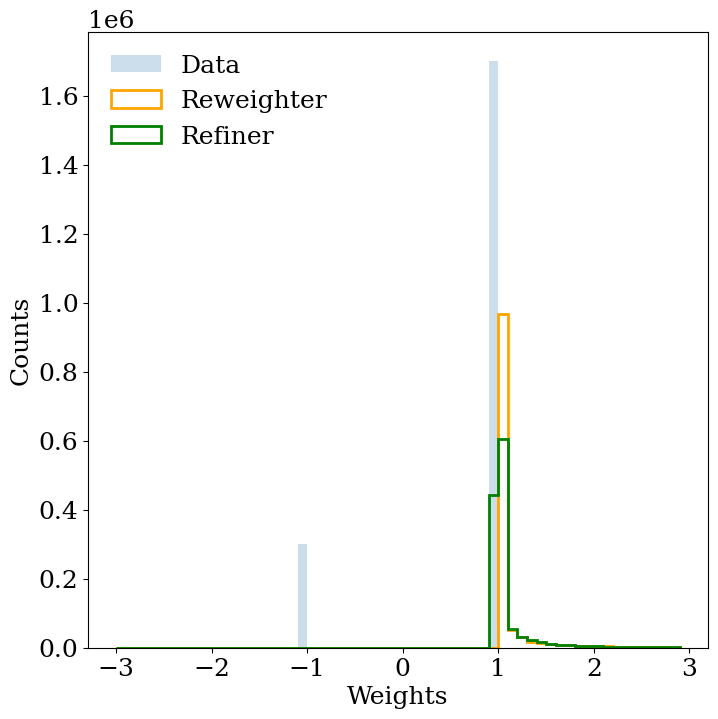

In [15]:
plot_w(data_natural, data_reweighter_resampled, data_resampler_resampled, bins=bins)

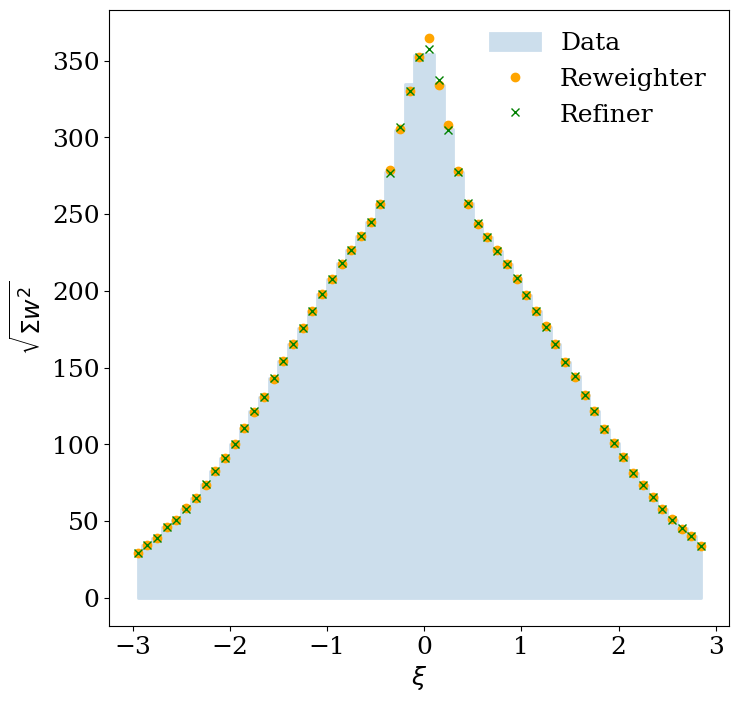

In [17]:
plot_w2(data_natural, data_reweighter_resampled, data_resampler_resampled, bins=bins)

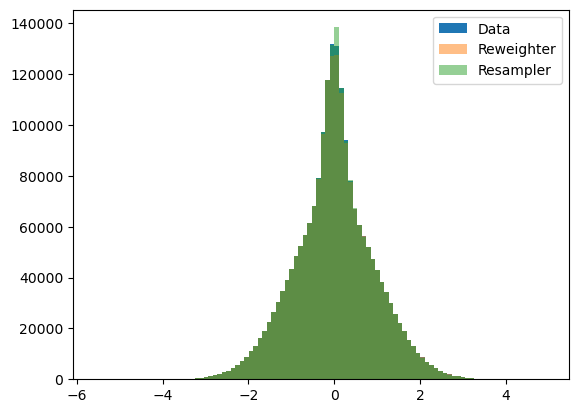

In [33]:
_, bins, __ = plt.hist(data_natural[0], weights=data_natural[-1]**2, bins=bins, label="Data")
_, __, ___ = plt.hist(data_reweighter_resampled[0], weights=data_reweighter_resampled[-1]**2, bins=bins, alpha=0.5, label="Reweighter")
_, __, ___ = plt.hist(data_resampler_resampled[0], weights=data_resampler_resampled[-1]**2, bins=bins, alpha=0.5, label="Resampler")
plt.legend()

In [34]:
data_resampler[-1]

array([1.9842322 , 1.984246  , 0.63991225, ..., 1.5035068 , 1.9842454 ,
       0.67475545], dtype=float32)

In [36]:
keep

array([ True,  True, False, ...,  True,  True,  True])

In [35]:
w

array([0.50397074, 0.5039672 , 0.5083399 , ..., 0.6651073 , 0.50396734,
       1.4819964 ], dtype=float32)

In [18]:
neweights = np.array(neweights)

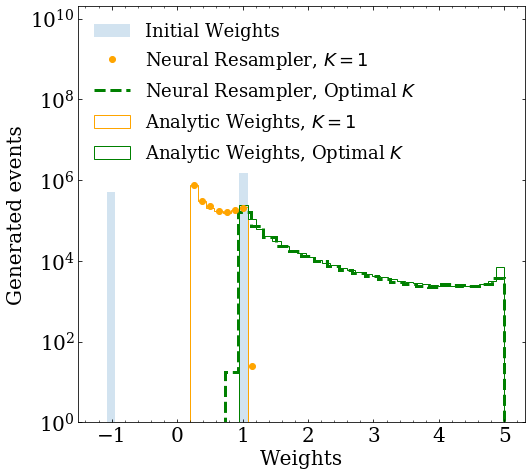

In [19]:
fig = plt.figure(figsize=(8, 7.65))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position("both")
ax0.xaxis.set_ticks_position("both")
ax0.tick_params(direction="in", which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(
    W_val[Y_val == 1], bins=np.linspace(-1.2, 5, 50), alpha=0.2, label="Initial Weights"
)

plt.hist(
    analytic_weights[Y_val == 0],
    label="Analytic Weights, $K=1$",
    color="orange",
    histtype="step",
    bins=np.linspace(-1.2, 5, 50),
    linewidth=1,
)
plt.hist(
    1.0 / analytic_weights[Y_val == 0],
    weights=analytic_weights[Y_val == 0] ** 2,
    label="Analytic Weights, Optimal $K$",
    color="green",
    histtype="step",
    bins=np.linspace(-1.2, 5, 50),
)

myn, bmjj = np.histogram(myw[Y_val == 0], bins=np.linspace(-1.2, 5, 50))
myn2, _ = np.histogram(-1000 * neweights, bins=np.linspace(-1.2, 5.0, 50))
myn2 += [0]
plt.plot(
    0.5 * (bmjj[1:] + bmjj[:-1]),
    myn,
    label=r"Neural Resampler, $K=1$",
    color="orange",
    marker="o",
    ls="",
)
plt.step(
    0.5 * (bmjj[1:] + bmjj[:-1]) + 0.5 * 6 / 50,
    myn2,
    label=r"Neural Resampler, Optimal $K$",
    color="green",
    ls="--",
    linewidth=3,
)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(
    [handles[2], handles[0], handles[1], handles[3], handles[4]],
    [labels[2], labels[0], labels[1], labels[3], labels[4]],
    frameon=False,
    fontsize=18,
    loc="upper left",
)
# plt.legend(frameon=False,fontsize=18)

# Binning artifacts in the last bin.
_, _, _ = plt.hist(
    neweights,
    bins=np.linspace(-1.2, 5.0, 33),
    weights=3 / 5.0 * np.ones(len(neweights)),
    color="green",
    ls="--",
    linewidth=3,
    histtype="step",
)

plt.xlabel(r"Weights", fontsize=20)
plt.ylim([1, 2e10])
plt.yscale("log")
plt.ylabel(r"Generated events", fontsize=20)
# plt.locator_params(axis='y', nbins=6)
plt.savefig("wgauss.pdf", bbox_inches="tight")

In [20]:
Bins_val = np.array([np.digitize(x, np.linspace(-3, 3, 51)) for x in X_val])

In [21]:
Bins_newval = np.array([np.digitize(x, np.linspace(-3, 3, 51)) for x in newxvals])

In [22]:
W2_original = [sum(W_val[(Y_val == 1) & (Bins_val == i)] ** 2) for i in range(51)]
W2_new = [sum(myw[(Y_val == 0) & (Bins_val == i)] ** 2) for i in range(51)]
W2_sampled = [sum(neweights[Bins_newval == i] ** 2) for i in range(51)]

L2_original = [len(W_val[(Y_val == 1) & (Bins_val == i)] ** 2) for i in range(51)]
L2_new = [len(myw[(Y_val == 0) & (Bins_val == i)] ** 2) for i in range(51)]
L2_sampled = [len(neweights[Bins_newval == i] ** 2) for i in range(51)]

In [23]:
W2_original = np.array(W2_original)
W2_new = np.array(W2_new)
W2_sampled = np.array(W2_sampled)

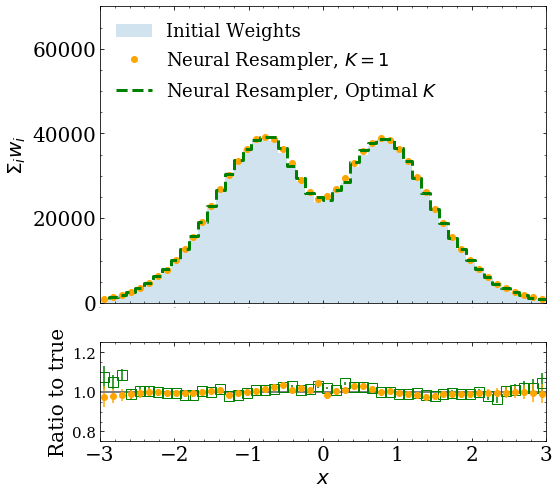

In [28]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position("both")
ax0.xaxis.set_ticks_position("both")
ax0.tick_params(direction="in", which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

myn2, _, _ = plt.hist(
    X_val[Y_val == 1],
    bins=np.linspace(-3, 3, 51),
    weights=W_val[Y_val == 1],
    alpha=0.2,
    label=r"Initial Weights",
)
# myn2,bmjj=np.histogram(X_val[Y_val==1],weights=W_val[Y_val==1],bins=np.linspace(-3,3,51))
# myn2,bmjj=np.histogram(X_val[Y_val==1],weights=W_val[Y_val==1],bins=np.linspace(-3,3,51)) #,alpha=0.5,label="Weighted")
myn3, bmjj = np.histogram(
    X_val[Y_val == 0], weights=myw[Y_val == 0][:, 0], bins=np.linspace(-3, 3, 51)
)  # ,label=r"Neural Positive Reweighter, $K=1$",histtype="step",color="orange",linewidth=5)
myn4, _ = np.histogram(
    newxvals, weights=neweights, bins=np.linspace(-3, 3, 51)
)  # ,label=r"Neural Positive Reweighter, Optimal $K$",histtype="step",color="green",ls=":",linewidth=5)

# plt.step(0.5*(bmjj[1:]+bmjj[:-1]),myn2,label=r"Initial Weights")
plt.plot(
    0.5 * (bmjj[1:] + bmjj[:-1]),
    myn3,
    label=r"Neural Resampler, $K=1$",
    ls="none",
    marker="o",
    color="orange",
)
plt.step(
    0.5 * (bmjj[1:] + bmjj[:-1]) + 0.5 * 6 / 51,
    myn4,
    label=r"Neural Resampler, Optimal $K$",
    ls="--",
    color="green",
    linewidth=3,
)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(
    [handles[2], handles[0], handles[1]],
    [labels[2], labels[0], labels[1]],
    frameon=False,
    fontsize=18,
    loc="upper left",
)
# plt.legend(frameon=False,fontsize=18,loc="upper left")
plt.xlim([-3, 3])
plt.ylim([0, 70000])
plt.ylabel(r"$\Sigma_i w_i$", fontsize=20)
plt.xlabel("", fontsize=20)
plt.xticks(fontsize=0)
plt.locator_params(axis="y", nbins=6)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.tick_params(direction="in", which="both")
ax1.minorticks_on()
plt.xlim([-3, 3])
plt.locator_params(axis="x", nbins=6)
plt.xlabel(r"$x$", fontsize=20)
plt.ylabel("Ratio to true", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1, linewidth=2, color="gray")
plt.errorbar(
    0.5 * (bmjj[1:] + bmjj[:-1]),
    myn3 / myn2,
    yerr=(W2_new[:, 0][:-1] + myn2) ** 0.5 / myn2,
    color="green",
    fmt="s",
    fillstyle="none",
    markersize=10,
)
plt.errorbar(
    0.5 * (bmjj[1:] + bmjj[:-1]),
    myn4 / myn2,
    yerr=(W2_sampled[:-1] + myn2) ** 0.5 / myn2,
    color="orange",
    fmt="o",
)
plt.ylim(0.75, 1.25)
# plt.xlim(-0.5,9.5)

plt.savefig("gauss_withK.pdf", bbox_inches="tight")

In [29]:
print(len(X_val[Y_val == 1]))
print(len(X_val[Y_val == 0]))
print(len(newxvals))
print(len(newxvals) / len(X_val[Y_val == 0]))

1999719
2000281
651607
0.3257577310387891


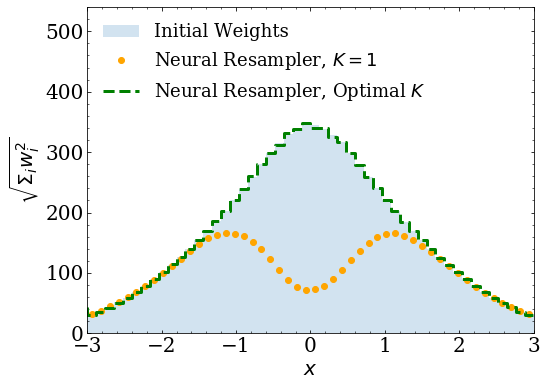

In [30]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position("both")
ax0.xaxis.set_ticks_position("both")
ax0.tick_params(direction="in", which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

bins = np.linspace(-3, 3, 51)

plt.hist([0, 1], [-1, -1], label="Initial Weights", alpha=0.2)
plt.fill_between(bins, np.array(W2_original) ** 0.5, step="pre", alpha=0.2)

plt.step(
    bins - 0.5 * 6 / 51,
    np.array(W2_new) ** 0.5,
    label=r"Neural Resampler, $K=1$",
    marker="o",
    ls="none",
    color="orange",
)
plt.step(
    bins,
    np.array(W2_sampled) ** 0.5,
    label=r"Neural Resampler, Optimal $K$",
    ls="--",
    linewidth=3,
    color="green",
)
# plt.legend(frameon=False,fontsize=18,loc="upper left")
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(
    [handles[2], handles[0], handles[1]],
    [labels[2], labels[0], labels[1]],
    frameon=False,
    fontsize=18,
    loc="upper left",
)

plt.ylim([0, 180 * 3])
plt.xlim([-3, 3])
plt.ylabel(r"$\sqrt{\Sigma_i w_i^2}$", fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.locator_params(axis="y", nbins=6)
plt.savefig("gauss_sumw2.pdf", bbox_inches="tight")

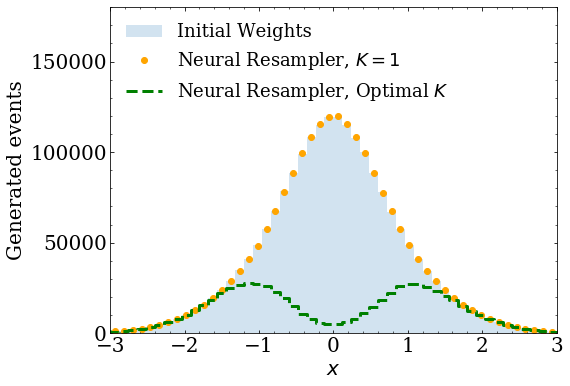

In [31]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position("both")
ax0.xaxis.set_ticks_position("both")
ax0.tick_params(direction="in", which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

# plt.step(bins,L2_original,label="Initial Weights")
plt.hist([0, 1], [-1, -1], label="Initial Weights", alpha=0.2)
plt.fill_between(bins, L2_original, step="pre", alpha=0.2)

plt.step(
    bins - 0.5 * 6 / 51,
    L2_new,
    label=r"Neural Resampler, $K=1$",
    marker="o",
    ls="none",
    color="orange",
)
plt.step(
    bins,
    L2_sampled,
    label=r"Neural Resampler, Optimal $K$",
    ls="--",
    linewidth=3,
    color="green",
)
# plt.legend(frameon=False,fontsize=18,loc="upper left")
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(
    [handles[2], handles[0], handles[1]],
    [labels[2], labels[0], labels[1]],
    frameon=False,
    fontsize=18,
    loc="upper left",
)

plt.ylim([0, 180000])
plt.ylabel("Generated events", fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.locator_params(axis="y", nbins=6)
plt.xlim([-3, 3])
plt.savefig("gauss_N.pdf", bbox_inches="tight")